## NLP Kaggle Challenge by Antonio Raffaele Iacovazzi - Mat: 756263 

##Loading libraries and data

In [ ]:
#importing libraries
import re
import numpy as np
import pandas as pd 
import seaborn as sns #data visualization
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.linear_model import SGDClassifier, LogisticRegression
from keras.preprocessing.text import text_to_word_sequence
from sklearn.tree import DecisionTreeClassifier
from copy import copy
import spacy

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import one_hot

from keras.models import Sequential, Model, load_model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Activation
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import Dropout

!pip install spacytextblob
!python -m textblob.download_corpora
!python -m spacy download en_core_web_sm

# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0
import os
import shutil
import tensorflow_hub as hub
import tensorflow_text as text

from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 

In [ ]:
#loading data
train = pd.read_table('/content/drive/MyDrive/NLP Sentiment Challenge/train.tsv')
test = pd.read_table('/content/drive/MyDrive/NLP Sentiment Challenge/test.tsv')
#check dataset
train.head()
#test.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


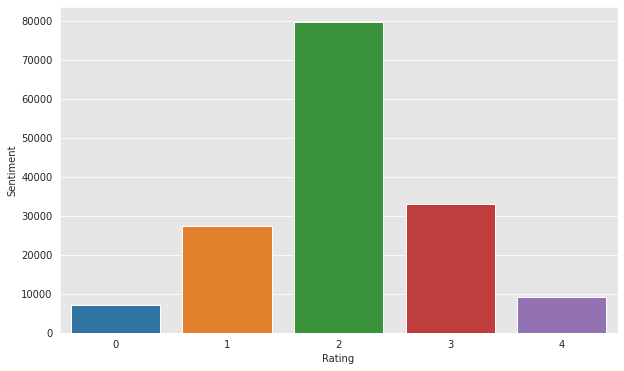

In [ ]:
#Visualization of data set
a = train.Sentiment.value_counts()
a = pd.DataFrame(a)
a['Rating'] = a.index
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(y='Sentiment', x='Rating', data=a)

The majority of sentences are in the neutral class. <br>
This probably because every review is splitted in sub-sentences and most of them are neutral.<br>
The dataset is really unbalanced, so it will be difficult to train on it properly.

# First attempt: a simple ML approach (useful for a baseline).<br>
Kaggle score: 0.61680

## Preprocessing steps

**Some consideration about stopwords removing in the movie review domain**:<br>
I think that the usual stopwords list doesn't fit in this kind of task, this because in sentiment analysis is necessary to catch some change of polarity in a sentence.<br>For example "not good" must be recognized as representative of the negative class.<br>In order to do this I will modify the stopwords set removing all the negation.<br>Furthermore I will add some recurrent words like "movie" and "film" that can't have a sentiment semantic in this domain because are the object of the discourse.

In [ ]:
#check if "movie" and "film" can be considered stopwords

word_vectorizer = CountVectorizer(ngram_range=(1,1), analyzer='word', min_df=0.001)
sparse_matrix = word_vectorizer.fit_transform(train['Phrase'])
frequencies = sum(sparse_matrix).toarray()[0]
freq = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names_out (), columns=['frequency'])
freq.sort_values('frequency', ascending=False)

#"film" has a frequency of 6733 and "movie" has a frequency of 6241, then i can consider this words stopwords.

,frequency
the,51633
of,32702
and,32177
to,22761
in,13997
...,...
girls,157
genuine,157
target,157
examination,157


In [ ]:
#creating a customized stopwords set
stop_words = stopwords.words('english') 
#print(stop_words)
r = re.compile("\w*n'\w*")
negation = list(filter(r.match, stop_words)) # Read Note below
#print(negation)
stop_words = set(stop_words)-set(negation)
stop_words=sorted(stop_words)
r = re.compile("\w*n$")
negation = list(filter(r.match, stop_words)) # Read Note below
#print(negation)
#select only real negation in the brief form
negation = [ 'ain', 'aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'mightn', 'mustn', 'needn', 'shouldn', 'wasn', 'weren',  'won', 'wouldn','no', 'nor', 'not']
stop_words = set(stop_words)-set(negation)
stop_words=sorted(stop_words)
#add "movie" and "film" in the list
stop_words.append('movie')
stop_words.append('movies')
stop_words.append('film')
stop_words.append('films')
print(stop_words)


['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'd', 'did', 'do', 'does', 'doing', 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'more', 'most', 'my', 'myself', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', 'she', "she's", 'should', "should've", 'so', 'some', 'such', 't', 'than', 'that', "that'll", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was', 'we', 'were', 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', '

**Defining the preprocessing pipeline**<br>
In order to work with less and more simple senteces, the following steps will be performed:<br>

*   Lowercase transformation
*   Numbers removing
*   Tokenization + symbol removing
*   Stopword removing
*   Stemming or Lemmatization










In [ ]:
lrb_rrb = ['lrb','rrb']
def preprocessDataset(text, split, stopword, normalization): 
    
    #remove single quotes 
    text = text.replace("'", "")    
    
    text = text.lower()

    numberremove_text = ''.join(c for c in text if not c.isdigit())

    #word tokenization using text-to-word-sequence
    tokenized_train_set = text_to_word_sequence(numberremove_text,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',split=" ")   

    #removing the special string lrb and rrb (brackets)
    tokenized_train_set = [i for i in tokenized_train_set if not i in lrb_rrb]

    #stop word removal
    if stopword == True:
      stopwordremoved_set = [i for i in tokenized_train_set if not i in stop_words]
    else:
      stopwordremoved_set = tokenized_train_set
        
    #Stemming
    if(normalization=='stem'):      
      norm_token_train_set = [stemmer.stem(word) for word in stopwordremoved_set]

    if(normalization=='lemma'):  
      #lemmatize each word to its lemma      
      norm_token_train_set = [lemmatizer.lemmatize(i) for i in stopwordremoved_set]

    if(normalization=='none'):  
      norm_token_train_set = stopwordremoved_set
     
    #join words into sentence
    if split == False:
      stopwordremove_text = ' '.join(norm_token_train_set)
    else:
      stopwordremove_text = norm_token_train_set #if we want the vector representation

    return stopwordremove_text

In [ ]:
processed_train = copy(train)
processed_train['Phrase'] = processed_train['Phrase'].apply(preprocessDataset, split=False, stopword = True, normalization= 'stem')
phrase = processed_train['Phrase']
sentiment = processed_train['Sentiment']
phrase.head()

0    seri escapad demonstr adag good goos also good...
1                 seri escapad demonstr adag good goos
2                                                 seri
3                                                     
4                                                 seri
Name: Phrase, dtype: object

In [ ]:
list_data = list(zip(phrase, sentiment))
train_set = pd.DataFrame(list_data,columns = ['Phrase', 'Sentiment'])
#remove empty rows 
train_set['Phrase'].replace('', np.nan, inplace=True)
train_set.dropna(subset = ["Phrase"], inplace=True)

## Training & Tests

The data are ready to be represented in a more suitable way for algorithms, here will use a bag of words model that is a simple matrix document X term where in each cell is represented the frequency of that word for that document.<br>
Instead of consider only single words also bigram (couple of word) will be taken into accout, this in order to catch the occurrence of negation or other two-words combination that can have a meaning per sé.

In [ ]:
#Hyperparameters
N_GRAM_MIN = 1 #the lower bound for n-gram representation
N_GRAM_MAX = 2 #the upper bound for n-gram representation
NUM_OF_SPLITS = 3

#create bag of words vector
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(ngram_range=(N_GRAM_MIN, N_GRAM_MAX),
min_df = 1) #bigrams
#Construct the required TF matrix by fitting and transforming the data
bow_matrix = bow.fit_transform(train_set['Phrase'])

#df = pd.DataFrame(data=bow_matrix.toarray(),columns = bow.get_feature_names()) #can crash with a lot of feature, better avoid to execute this
#df

Now the BoW representation will feed three classical machine learning algorithm that are:

*   Linear Support Vector Machine
*   Decision Tree
*   Logistic Regression
*   Naive Bayes

In order to evaluate their performance a 3-fold cross validation is performed.<br>
By means of this technique is possible to stress the algorithm with different combination of train and validation set obtaining so more meningful result about accuracy.<br>
The 3-fold is used to speed up the search for good hyperparaters, once done this a final evluation with the 10-fold will be done.



In [ ]:
from sklearn.svm import LinearSVC
models = []
models.append(('Support Vector Machine',LinearSVC(max_iter=9000)))
models.append(('Decision Tree',DecisionTreeClassifier()))
models.append(('Logistic Regression',LogisticRegression(max_iter=9000)))
models.append(('Bayes',MultinomialNB()))


In [ ]:
# compare models with 10-fold cross-validation
kf = model_selection.StratifiedKFold(n_splits=NUM_OF_SPLITS,shuffle=True, random_state = 1)

for name, model in models:
    cv_scores = model_selection.cross_val_score(model, bow_matrix, train_set['Sentiment'], cv=kf)
    msg = "%s: %f (%f)" % (name, cv_scores.mean(), cv_scores.std())
    print(msg)

Support Vector Machine: 0.637928 (0.001071)
Decision Tree: 0.622404 (0.000902)
Logistic Regression: 0.652863 (0.000727)
Bayes: 0.604885 (0.002361)


## Evaluating Results
Results are presented in the following way:<br>
name_of_algorithm: average_accuracy(standard_deviation)

**Results with:** <br>
*N_GRAM_MIN = 1*<br>
*N_GRAM_MAX = 1*<br>

---
Support Vector Machine: 0.618291 (0.001244)<br>
Decision Tree: 0.622339 (0.001535)<br>
Logistic Regression: 0.631030 (0.002014)<br>
Bayes: 0.602637 (0.000442)<br>


**Results with:** <br>
*N_GRAM_MIN = 1*<br>
*N_GRAM_MAX = 2*<br>

---
Support Vector Machine: 0.640506 (0.001193)<br>
Decision Tree: 0.623136 (0.001891)<br>
Logistic Regression: 0.653983 (0.001412)<br>
Bayes: 0.612974 (0.002300)<br>
The results are increased a lot, this probably because the presence of 2-grams allows to better distinguish between classes.

**Results with:** <br>
*N_GRAM_MIN = 2*<br>
*N_GRAM_MAX = 2*<br>


---


Support Vector Machine: 0.623848 (0.000649)<br>
Decision Tree: 0.616905 (0.000745)<br>
Logistic Regression: 0.619282 (0.001219)<br>
Bayes: 0.598855 (0.001755)<br>
Here only bigrams are taken into account, the results are lower than before and also compared to the experiment with only unigrams, probably bigrams are not sufficiently expressive alone to well separate the various class.

**Results with:** <br>
*N_GRAM_MIN = 2*<br>
*N_GRAM_MAX = 3*<br>

---
Support Vector Machine: 0.624029 (0.000518)<br>
Decision Tree: 0.617048 (0.000733)<br>
Logistic Regression: 0.616963 (0.001334)<br>
Bayes: 0.590014 (0.002135)<br>
Here we have bigrams and trigrams, the results is slightly lower than the previous in front of an increased complexity of the model.<br>
This shows that my initial assumption about n-grams with n>1 was good but only combining unigram and bigram.<br>
I will work with the unigram+bigram in this ML context.

This result suggest us that the Logistic Regression classifier is the best choice among the three classifier.<br>
An accuracy of 0.65 on the validation set is pretty high considering the kind of task. Let's see how it behave on the actual test set.

In [ ]:
final_model = LogisticRegression(max_iter=9000)
final_model.fit(bow_matrix, train_set['Sentiment'])

processed_test = test

processed_test['Phrase'] = processed_test['Phrase'].apply(preprocessDataset, split=False, stopword = True, normalization= 'stem')

test_id = processed_test['PhraseId']
test_text = processed_test['Phrase']
bow_matrix_test = bow.transform(processed_test['Phrase'])

print(bow_matrix_test.shape)

y_prdict = final_model.predict(bow_matrix_test)

submission = pd.DataFrame(list(zip(test_id, y_prdict)),
               columns =['PhraseId', 'Sentiment'])
submission.head(20)

submission.to_csv('/content/drive/MyDrive/NLP Sentiment Challenge/submission_logistic.csv', index=False)
#renamed submission_test
#kaggle score: 0.61680

(66292, 72825)


End up with an accuracy of 0.61680 that is really good considering the simple model and the complexity of the task.

# Second Attempt: an heuristic way based on senti-wordnet + ML technique.
Kaggle score 0.54193<br>


Another way to approach this kind of tasks is using a lexicon made up with the purpose of represent the sentiment content of each word in english.<br>


## What I want to do?



*Training phase:*

1.   For each review create a set of negated words and the set of normal words (where the polarity is directly taken from sentiwordnet).
2.   Compute the sentiment score of the two sets, invert the score of the negated set.
3.   Compute the overall sentiment of the sentence summing all the scores (negative and positive), then obtain a final score as a single value by the *formula tot_pos_score - tot_neg_score* or as a triplet [pos_value, neg_value, obj_value]. 

4. Try to derive a rule using the results of the previous algorithm, if it is bad the train a ML model in order to try to map every score to a class [0,4].

*Test phase:*
1.   Compute the sentiment score of the sentence (steps 1-2-3 of the training phase).
2. Try to predict the right class passing in input the score to the ML model.

## Creating the algorithm

In [ ]:
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
nltk.download('sentiwordnet')
nltk.download('omw-1.4')
#Here I dont remove negation from stopwords, I will deal with negation using the algoritm previous described, then once made the two sets, all the common stopword will be removed.
nlp = spacy.load('en_core_web_sm')
nlp.Defaults.stop_words |= {"movie","film"}

[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
#this simple program converts the POS of spacy into the one accepted by nltk-sentiwordnet
def spacy_to_wn(tag):
    if tag=='ADJ':
        return wn.ADJ
    elif tag == 'NOUN':
        return wn.NOUN
    elif tag=='ADV':
        return wn.ADV
    elif tag == 'VERB':
        return wn.VERB
    return None

In [ ]:
def get_sentiment(word,tag,mod):
    """ returns list of pos neg and objective score. But returns empty list if not present in senti wordnet. """

    wn_tag = spacy_to_wn(tag)
    if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV,  wn.VERB):
        return [0,0,0]

    synsets = wn.synsets(word, pos=wn_tag)
    if not synsets:
        return [0,0,0]

    # Take the first sense, the most common
    synset = synsets[0]
    swn_synset = swn.senti_synset(synset.name())

    if mod == 'normal':
      return [swn_synset.pos_score(), swn_synset.neg_score(), swn_synset.obj_score()]
    
    if mod == 'negated':
      return [swn_synset.neg_score(), swn_synset.pos_score(), swn_synset.obj_score()]

In [ ]:
def get_sentiment_array(text, neg_factor, debug):

  doc = nlp(text)

  negation_tokens = [tok for tok in doc if tok.dep_ == 'neg']

  punctation_tokens = [tok for tok in doc if tok.dep_ == 'punct']

  normal = []
  negated = []

  neg = False

  for tok in doc:
    if neg == False:
      if tok in negation_tokens:
        neg = True
        normal.append([tok.lemma_.lower(),'ADV']) #lemmatized version of the token, for senti_wordnet "not" is an adverb, so I force this conversion. I take into account negation in the normal context because have a strong polarity in sw.
      else:
        if not(tok in punctation_tokens): #in this case word goes to normal bucket but discard punctuation
          if not(tok.is_stop):
            normal.append([tok.lemma_.lower(),tok.pos_]) #lemmatized version of the token
    else:
      if tok in punctation_tokens:
        neg = False
      else:      
        if not(tok in negation_tokens): #in negation context new negation are discarded (still in negative polarity)
          if not(tok.is_stop):
            negated.append([tok.lemma_.lower(),tok.pos_]) #lemmatized version of the token

  if debug==True:
    scores = [get_sentiment(x,y,'normal') for (x,y) in normal]

    nr = list(zip(normal,scores))

    neg_scores = [get_sentiment(x,y,'negated') for (x,y) in negated]

    neg = list(zip(negated,neg_scores))

    print (nr)

    print (neg)

  senti_val_nor = [get_sentiment(x,y,'normal') for (x,y) in normal]
  senti_val_neg = [get_sentiment(x,y,'normal') for (x,y) in negated]

  return senti_val_nor+senti_val_neg


In [ ]:
def get_sentiment_score (array):
  pos = sum( x[0] for x in array)
  neg = sum( x[1] for x in array)
  return pos-neg

In [ ]:
def get_sentiment_triplet (array):
  pos = sum( x[0] for x in array)
  neg = sum( x[1] for x in array)
  obj = sum( x[2] for x in array)
  return [pos,neg,obj]
   

## Applyng the algorithm on a smaller training set
In order to catch the behaviour of the algorithm i will work on a small training set made of full reviews only, this in order to use less time since the previous algorithm is quite slow on the full training set.

In [ ]:
sentence_id = train.groupby(['SentenceId'])['PhraseId'].min()
sentence_id = [x - 1 for x in sentence_id]
train_or =  train.iloc[sentence_id] #train only (full) reviews

scores = train_or['Phrase'].apply(get_sentiment_array, neg_factor=1, debug=False).apply(get_sentiment_score)

sentiment = train_or['Sentiment']
phrase = train_or['Phrase']

list_data = list(zip(phrase,scores, sentiment))
train_set_or = pd.DataFrame(list_data,columns = ['Phrase','Score', 'Sentiment'])

In [ ]:
train_set_or

,Phrase,Score,Sentiment
0,A series of escapades demonstrating the adage ...,2.625,1
1,"This quiet , introspective and entertaining in...",0.250,4
2,"Even fans of Ismail Merchant 's work , I suspe...",-1.000,1
3,A positively thrilling combination of ethnogra...,-2.125,3
4,Aggressive self-glorification and a manipulati...,1.000,1
...,...,...,...
8524,... either you 're willing to go with this cla...,-0.250,2
8525,"Despite these annoyances , the capable Claybur...",0.375,2
8526,-LRB- Tries -RRB- to parody a genre that 's al...,0.375,1
8527,The movie 's downfall is to substitute plot fo...,-0.875,1


## Some analysis on the results + simple classification algorithm<br>
I excpect that for the positive review the score is positive and for the negative one is negative. <br> I also excpect some errors tha could bring noise in the training phase.

In [ ]:
#Get all the set separated by class
s0 = train_set_or.query("`Sentiment` == 0")
s1 = train_set_or.query("`Sentiment` == 1")
s2 = train_set_or.query("`Sentiment` == 2")
s3 = train_set_or.query("`Sentiment` == 3")
s4 = train_set_or.query("`Sentiment` == 4")
#The mean will represent the tipycal score assumed by every class
ms0 = s0["Score"].mean()
ms1 = s1["Score"].mean()
ms2 = s2["Score"].mean()
ms3 = s3["Score"].mean()
ms4 = s4["Score"].mean()

print(ms0)
print(ms1)
print(ms2)
print(ms3)
print(ms4)

-0.26898507462686566
-0.08341318181818183
-0.0032283987915407864
0.22833003015941403
0.47886651053864177


ms0 = -0.26898507462686566<br>
ms1 = -0.08341318181818183<br>
ms2 = -0.0032283987915407864<br>
ms3 = 0.22833003015941403<br>
ms4 = 0.47886651053864177<br>

This means values are quite promising, here clearly see how every class a distinct mean value that represent the overall polarity of the sentences.<br>
A first, naive, approach to exploit this information can be define some tresholds that define the class given a score.

In [ ]:
global t0
global t1
global t2
global t3
t0 =  (ms0+ms1)/2
t1 =  (ms1+ms2)/2
t2 =  (ms2+ms3)/2
t3 =  (ms3+ms4)/2
print(t0)
print(t1)
print(t2)
print(t3)

-0.17619912822252376
-0.04332079030486131
0.11255081568393661
0.3535982703490279


t0 = -0.17619912822252376<br>
t1 = -0.04332079030486131<br>
t2 = 0.11255081568393661<br>
t3 = 0.3535982703490279<br>

These tresholds will be used to determine the class by the following way:<br>


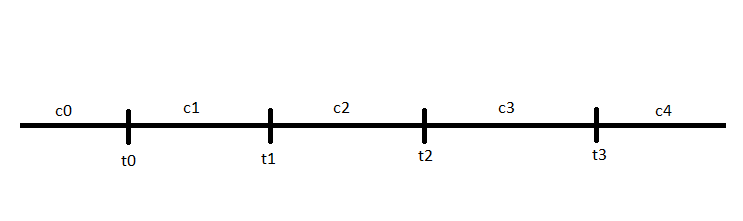

In [ ]:
def determine_class(score):
  if score < t0:
    return 0
  elif score >= t0 and score <= t1:
    return 1
  elif score >= t1 and score <= t2:
    return 2
  elif score >= t2 and score <= t3:
    return 3
  elif score > t3:
    return 4

In [ ]:
derived_sentiment = train_set_or['Score'].apply(determine_class)
list_data = list(zip(phrase,scores, sentiment,derived_sentiment))
train_set_or = pd.DataFrame(list_data,columns = ['Phrase','Score', 'Sentiment','Derived_Sentiment'])
train_set_or

,Phrase,Score,Sentiment,Derived_Sentiment
0,A series of escapades demonstrating the adage ...,2.625,1,4
1,"This quiet , introspective and entertaining in...",0.250,4,3
2,"Even fans of Ismail Merchant 's work , I suspe...",-1.000,1,0
3,A positively thrilling combination of ethnogra...,-2.125,3,0
4,Aggressive self-glorification and a manipulati...,1.000,1,4
...,...,...,...,...
8524,... either you 're willing to go with this cla...,-0.250,2,0
8525,"Despite these annoyances , the capable Claybur...",0.375,2,4
8526,-LRB- Tries -RRB- to parody a genre that 's al...,0.375,1,4
8527,The movie 's downfall is to substitute plot fo...,-0.875,1,0


Let's see how good is this model for each class computing precision and recall:

In [ ]:
#Number of record for every derived class
ds0 = train_set_or.query("`Derived_Sentiment` == 0")
ds1 = train_set_or.query("`Derived_Sentiment` == 1")
ds2 = train_set_or.query("`Derived_Sentiment` == 2")
ds3 = train_set_or.query("`Derived_Sentiment` == 3")
ds4 = train_set_or.query("`Derived_Sentiment` == 4")

num_d0_class = ds0.shape[0]
num_d1_class = ds1.shape[0]
num_d2_class = ds2.shape[0]
num_d3_class = ds3.shape[0]
num_d4_class = ds4.shape[0]

#Number of record for every actual class
num_0_class = s0.shape[0]
num_1_class = s1.shape[0]
num_2_class = s2.shape[0]
num_3_class = s3.shape[0]
num_4_class = s4.shape[0]

#precision and recall for 0 class
rel_retr_0 = (train_set_or.query("`Derived_Sentiment` == 0 and `Sentiment` == 0").shape[0]) #intersecion between the relevant and the retrieved
p0 = rel_retr_0/num_d0_class #precision = itersection/retrieved document
r0 = rel_retr_0/num_0_class #recall = itersection/relevant document

print('Precision for the class 0: '+str(p0))
print('Recall for the class 0: '+str(r0))
print('')
#precision and recall for 1 class
rel_retr_1 = (train_set_or.query("`Derived_Sentiment` == 1 and `Sentiment` == 1").shape[0]) #intersecion between the relevant and the retrieved
p1 = rel_retr_1/num_d1_class #precision = itersection/retrieved document
r1 = rel_retr_1/num_1_class #recall = itersection/relevant document

print('Precision for the class 1: '+str(p1))
print('Recall for the class 1: '+str(r1))
print('')

#precision and recall for 2 class
rel_retr_2 = (train_set_or.query("`Derived_Sentiment` == 2 and `Sentiment` == 2").shape[0]) #intersecion between the relevant and the retrieved
p2 = rel_retr_2/num_d2_class #precision = itersection/retrieved document
r2 = rel_retr_2/num_2_class #recall = itersection/relevant document

print('Precision for the class 2: '+str(p2))
print('Recall for the class 2: '+str(r2))
print('')

#precision and recall for 3 class
rel_retr_3 = (train_set_or.query("`Derived_Sentiment` == 3 and `Sentiment` == 3").shape[0]) #intersecion between the relevant and the retrieved
p3 = rel_retr_3/num_d3_class #precision = itersection/retrieved document
r3 = rel_retr_3/num_3_class #recall = itersection/relevant document

print('Precision for the class 3: '+str(p3))
print('Recall for the class 3: '+str(r3))
print('')

#precision and recall for 4 class
rel_retr_4 = (train_set_or.query("`Derived_Sentiment` == 4 and `Sentiment` == 4").shape[0]) #intersecion between the relevant and the retrieved
p4 = rel_retr_4/num_d4_class #precision = itersection/retrieved document
r4 = rel_retr_4/num_4_class #recall = itersection/relevant document

print('Precision for the class 4: '+str(p4))
print('Recall for the class 4: '+str(r4))
print('')

accuracy = (rel_retr_0 + rel_retr_1 + rel_retr_2 +rel_retr_3 + rel_retr_4)/train_set_or.shape[0]
print('Overall accuracy of the algorithm '+str(accuracy))
print('')

Precision for the class 0: 0.20204153467089053
Recall for the class 0: 0.5354477611940298

Precision for the class 1: 0.2964426877470356
Recall for the class 1: 0.06818181818181818

Precision for the class 2: 0.2897998093422307
Recall for the class 2: 0.18368580060422962

Precision for the class 3: 0.2718360071301248
Recall for the class 3: 0.13140887548470487

Precision for the class 4: 0.2497509133178346
Recall for the class 4: 0.5870413739266198

Overall accuracy of the algorithm 0.24446007738304606



Precision for the class 0: 0.20204153467089053<br>
Recall for the class 0: 0.5354477611940298<br>
<br>
Precision for the class 1: 0.2964426877470356<br>
Recall for the class 1: 0.06818181818181818<br>
<br>
Precision for the class 2: 0.2897998093422307<br>
Recall for the class 2: 0.18368580060422962<br>
<br>
Precision for the class 3: 0.2718360071301248<br>
Recall for the class 3: 0.13140887548470487<br>
<br>
Precision for the class 4: 0.2497509133178346<br>
Recall for the class 4: 0.5870413739266198<br>
<br>
Overall accuracy of the algorithm 0.24446007738304606

Here is clear that this algorithm is really bad.<br>
There is a higher recall on the two extreme class, but for the inner ones it cannot classify the sentences properly.<br>
Probably a better choose of the tresholds can increase performace, but I think that the score measure is really instable and cannot provide a valid ground for derive a rule to make proper classification.<br>


In [ ]:
#example for which a different treshold cannot make any difference:

#negative class 0 and 1 shouldn't have positive scores
eds0 = train_set_or.query("`Sentiment` == 0 and `Score` >= 0").shape[0]
eds1 = train_set_or.query("`Sentiment` == 1 and `Score` >= 0").shape[0]

#positive class 3 and 4 shouldn't have negative scores
eds3 = train_set_or.query("`Sentiment` == 3 and `Score` <= 0").shape[0]
eds4 = train_set_or.query("`Sentiment` == 4 and `Score` <= 0").shape[0]
print('Completely wrong scores for 0: '+str(eds0) +  ' over '+str(num_0_class))
print('Completely wrong scores for 1: '+str(eds1) +  ' over '+str(num_1_class))
print('Completely wrong scores for 3: '+str(eds3) +  ' over '+str(num_3_class))
print('Completely wrong scores for 4: '+str(eds4) +  ' over '+str(num_4_class))

print('')

Completely wrong scores for 0: 437 over 1072
Completely wrong scores for 1: 1117 over 2200
Completely wrong scores for 3: 966 over 2321
Completely wrong scores for 4: 351 over 1281



This because this algorithm rely on the assumption that the spacy pos tagger is always correct, and the SentiWordnet scores always reflect a proper sentiment for the word.<br>
Furthermore this algorithm has a naive management of negation and can't deal whit inversion of polarity bring by word such as "but", "however" and so on. This is certainly a possible enhancement.<br>
Finally there too many reviews that use words in a counterintuitive way using game of words, way of saying and so on, often a good review can use words that are negative in SentiWordnet and viceversa.
Some example of misclasification:

In [ ]:
print('Class 4 example:')
t = "Majidi 's direction has never been smoother or more confident ."
print(get_sentiment_score(get_sentiment_array(t, 1, True)))
print('Here the negation is used in a wat that reinforce the polarity. This trick is ignored.')
print('')

t = "A moving and not infrequently breathtaking film."
print(get_sentiment_score(get_sentiment_array(t, 1, True)))
print('The word breathtaking has any polarity, probably because is parsed as a verb by spacy.')
print('')

t = "Well-acted , well-directed and , for all its moodiness , not too pretentious "
print(get_sentiment_score(get_sentiment_array(t, 1, True)))
print('The word well is considered a stopword and the removed, the word pretentious has a negative score in the negated context, this because is probably considered a positive word by sentiwordnet.')
print('')

t = "The film boasts dry humor and jarring shocks , plus moments of breathtaking mystery ."
print(get_sentiment_score(get_sentiment_array(t, 1, True)))
print('Words like dry and shocks are considered negative, so this influence the overall polarity of the sentence.')
print('')

print('Class 0 example:')
t = "is that it 's a crime movie made by someone who obviously knows nothing about crime."
print(get_sentiment_score(get_sentiment_array(t, 1, True)))
print('Obviously is considered a positive word, the complex semantic of the sentence is not manageble by the sentiwordnet algorithm.')
print('')

t = "My precious new Star Wars movie is a lumbering , wheezy drag ..."
print(get_sentiment_score(get_sentiment_array(t, 1, True)))
print('Only the words precious and new gets a score. A positive one. This influence the overall polarity.')
print('')

t = "Philosophically , intellectually and logistically a mess ."
print(get_sentiment_score(get_sentiment_array(t, 1, True)))
print('Philosophically and intellectually gets a positive score. The word mess has not a sufficient negative score to influence the overall sentiment of the sentence.')
print('')

Class 4 example:
[(['majidi', 'PROPN'], [0, 0, 0]), (['direction', 'NOUN'], [0.0, 0.0, 1.0]), (['never', 'ADV'], [0.0, 0.625, 0.375])]
[(['smooth', 'ADJ'], [0.0, 0.25, 0.75]), (['confident', 'ADJ'], [0.0, 0.375, 0.625])]
0.0
Here the negation is used in a wat that reinforce the polarity. This trick is ignored.

[(['move', 'VERB'], [0.0, 0.0, 1.0]), (['not', 'ADV'], [0.0, 0.625, 0.375])]
[(['infrequently', 'ADV'], [0.0, 0.0, 1.0]), (['breathtake', 'VERB'], [0, 0, 0])]
-0.625
The word breathtaking has any polarity, probably because is parsed as a verb by spacy.

[(['act', 'VERB'], [0.0, 0.0, 1.0]), (['direct', 'VERB'], [0.0, 0.0, 1.0]), (['moodiness', 'NOUN'], [0.125, 0.875, 0.0]), (['not', 'ADV'], [0.0, 0.625, 0.375])]
[(['pretentious', 'ADJ'], [0.125, 0.375, 0.5])]
-1.125
The word well is considered a stopword and the removed, the word pretentious has a negative score in the negated context, this because is probably considered a positive word by sentiwordnet.

[(['boast', 'VERB'], [0.0

However we can try to use the full dataset to derive a score and then train a ML model to convert a score into a class.<br>
I do not expect big improvement since the score itself suffer of severe biases, however, I'll make a try.

## Training a ML model to convert scores into classes

First of all the computation of the sentiment score for each word of each sentence is performed, this first step take a bit of time, about 15 minutes.

In [ ]:
scores_array = train['Phrase'].apply(get_sentiment_array, neg_factor=1, debug=False)


In [ ]:
from sklearn.svm import LinearSVC

scores = scores_array.apply(get_sentiment_score)
sentiment = train['Sentiment']
phrase = train['Phrase']
list_data = list(zip(phrase, sentiment))
train_set = pd.DataFrame(list_data,columns = ['Phrase','Sentiment'])

models = []
models.append(('Support Vector Machine',LinearSVC(max_iter=9000)))
models.append(('Decision Tree',DecisionTreeClassifier()))
models.append(('Logistic Regression',LogisticRegression(max_iter=9000)))

# compare models with 3-fold cross-validation
kf = model_selection.StratifiedKFold(n_splits=3,shuffle=True, random_state = 1)

scores = scores.values.reshape(-1,1)

for name, model in models:
    cv_scores = model_selection.cross_val_score(model, scores, train_set['Sentiment'], cv=kf)
    msg = "%s: %f (%f)" % (name, cv_scores.mean(), cv_scores.std())
    print(msg)

Support Vector Machine: 0.512566 (0.000220)
Decision Tree: 0.530495 (0.000941)
Logistic Regression: 0.517826 (0.000199)


The tests made using a 3-fold cross validation ends up with the following results: <br>
Support Vector Machine: 0.512566 (0.000220)<br>
Decision Tree: 0.530495 (0.000941)<br>
Logistic Regression: 0.517826 (0.000199)<br>
These results are surely better than the one obtained using my algorithm, however are not better than the ones obtained in the previous section, rather, are drastically lower. <br>


---

A way to improve these results can be trying to use the array with three values of polarities instead of using my derived score.<br>
Probably my single score loose some hidden pattern in the scoring of words that can end up to be exploited by the models in order to improve their accuracy.

In [ ]:
scores = scores_array.apply(get_sentiment_triplet)
scores =  pd.DataFrame.from_records(scores).to_numpy()

In [ ]:
models = []
models.append(('Decision Tree',DecisionTreeClassifier()))
models.append(('Logistic Regression',LogisticRegression(max_iter=9000)))
models.append(('Bayes',MultinomialNB()))
#SVC removed since it does not converge in this context, i put Bayes in it's place since now we dealk with only positive value and then is usable.
for name, model in models:
    cv_scores = model_selection.cross_val_score(model, scores, train_set['Sentiment'], cv=kf)
    msg = "%s: %f (%f)" % (name, cv_scores.mean(), cv_scores.std())
    print(msg)

Decision Tree: 0.536909 (0.001286)
Logistic Regression: 0.530142 (0.001608)
Bayes: 0.510111 (0.000125)


The tests made using a 3-fold cross validation ends up with the following results:<br>
Decision Tree: 0.536909 (0.001286)<br>
Logistic Regression: 0.530142 (0.001608)<br>
Bayes: 0.510111 (0.000125)<br>

These results are queite similar to the previous, so these kind of machine learnign model cannot exploit the sentiment array properly in order to obtain information about the right class.<br>
This, as said before, is probably imputable to the inherent complexity of the task.

## Training a Neural Network model to convert scores into classes

Before give up and go on with other technique I want to make a last experiment using the sentiwordnet feature.<br>
Using the previuos arrays of three component [pos,neg,obj] derived for each review, i want try to train a neural network and see if a more complex model is capable of extract some hidden rule that allow to correct classify the review starting from the polarity array.

In [ ]:
def buildmodel():
    model = keras.Sequential([
    keras.layers.Flatten(input_shape=(3,1)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),#regularization
    keras.layers.Dense(16, activation='relu'),  
    keras.layers.Dense(5, activation='softmax')
    ])
    model.summary()
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return(model)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(scores,sentiment, test_size = 0.3, random_state = 60,shuffle=True, stratify=sentiment)
model = buildmodel()
# model fitting
model.fit(X_train, Y_train,  validation_data=(X_test, Y_test)) 



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 3)                 0         
                                                                 
 dense_6 (Dense)             (None, 64)                256       
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 16)                1040      
                                                                 
 dense_8 (Dense)             (None, 5)                 85        
                                                                 
Total params: 1,381
Trainable params: 1,381
Non-trainable params: 0
_________________________________________________________________
3414/3414 [==============================] - 13s 3ms

In [ ]:
final_model = buildmodel()
final_model.fit(scores, train_set['Sentiment'])

processed_test = scores_array = test['Phrase'].apply(get_sentiment_array, neg_factor=1, debug=False)
processed_test = processed_test.apply(get_sentiment_triplet)
processed_test =  pd.DataFrame.from_records(processed_test).to_numpy()

test_id = test['PhraseId']

y_prdict = final_model.predict(processed_test)
y = np.argmax(y_prdict, axis=1)
submission = pd.DataFrame(list(zip(test_id, y)),
               columns =['PhraseId', 'Sentiment'])
submission.head(20)

submission.to_csv('/content/drive/MyDrive/NLP Sentiment Challenge/submission_test_swnn.csv', index=False)
#kaggle score: 0.54193  \

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 3)                 0         
                                                                 
 dense_9 (Dense)             (None, 64)                256       
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 16)                1040      
                                                                 
 dense_11 (Dense)            (None, 5)                 85        
                                                                 
Total params: 1,381
Trainable params: 1,381
Non-trainable params: 0
_________________________________________________________________
4877/4877 [==============================] - 12s 2ms

Training with 10 epoch and validation set ends up with the following results:<br>
Multi Layer Perceptron: 0.5245 (may vary on several runs)<br>
Kaggle score: 0.54193

---

This is the best between every tests made using the polarity array.<br>
However the accuracy is really far for the one reached using the previous approach.<br>
Probably is still possible to increase this results crafting a more sophisticated algorithm that is capable of catch sentiment inversion also when words like "but", "however", "instead" are used, or when the negation are used as reinforcement ("I never been so happy") or as a smoothing ("It's not so bad) where there is not a real inversion, but just a decrease of the original sentiment.<br>
All this nuances are not managed by my simple algorithm and to be honest, the natural language is so full of trick that I think is really difficult to use this kind of method in a context like this one.<br>
We need more powerful method that are capable of extract the semantic of words without too much human intervention on the kind of words and pattern that are useful for the task.<br>
These model are the LSTM Neural Networks and the Tranformers.

#Third attempt: LSTM and GRU
Kaggle score for LSTM: 0.62511<br>
Kaggle score for GRU: 0.62256

LSTM (long short term memory) and GRU (gated recurrent unit) are two kind of neural network that can be viewed as an evolution of Recurrent Neural Network, overcoming their limitation about the vanishing gradient problem which doesn't allow to keep track of a sufficient amount of information.<br>
These two model are really good in dealing with sequence of data like texts or sounds, so will be used to try to resolve our sentiment analysis problem.

In [ ]:
#reloading data... Just to be sure
train = pd.read_table('/content/drive/MyDrive/NLP Sentiment Challenge/train.tsv')
test = pd.read_table('/content/drive/MyDrive/NLP Sentiment Challenge/test.tsv')

##Preprocessing 

In order to feed the neural network we need, as in the previuos experiments, to preprocess the data in order to make more simple to deal with the text.<br>
I will apply the a different sequence of preprocessing step since LSTM are more sensible to the order of words, so i will not remove stopwords.

In [ ]:
processed_train = copy(train)
processed_train['Phrase'] = processed_train['Phrase'].apply(preprocessDataset, split = True, stopword = False, normalization = 'stem')
phrase = processed_train['Phrase']
sentiment = processed_train['Sentiment']


Now every words need to be transformed into a numerical value in order to be manageable by models.<br>
The most simple way to deal with this is the one hot encoding, i will use the one offered by keras.

In [ ]:
def get_vocabulary_stats(phrases):
  unique_words = set()
  len_max = 0

  for sent in phrases:
      
      unique_words.update(sent)
      
      if(len_max<len(sent)):
          len_max = len(sent)
          
  #length of the list of unique_words gives the no of unique words
  tot_word = len(list(unique_words))
  #print(tot_word)
  #print(len_max)
  #print(unique_words)
  return(tot_word,len_max)

voc_stats=get_vocabulary_stats(phrase)
encoded_phrases = [one_hot(' '.join(d), voc_stats[0], lower = False) for d in phrase]
encoded_phrases = keras.preprocessing.sequence.pad_sequences(encoded_phrases, maxlen=voc_stats[1])

print(encoded_phrases)

[[   0    0    0 ... 3209 1941  147]
 [   0    0    0 ... 4386 2644 7913]
 [   0    0    0 ...    0 1941 6872]
 ...
 [   0    0    0 ...    0 7868 7318]
 [   0    0    0 ...    0    0 7868]
 [   0    0    0 ...    0    0 7318]]


In [ ]:
processed_test = copy(test)
processed_test['Phrase'] = processed_test['Phrase'].apply(preprocessDataset, split = True, stopword = False, normalization = 'stem')
test_phrase = processed_test['Phrase']
test_voc_stats=get_vocabulary_stats(test_phrase)
encoded_test_phrases = [one_hot(' '.join(d), voc_stats[0], lower = False) for d in test_phrase]
encoded_test_phrases = keras.preprocessing.sequence.pad_sequences(encoded_test_phrases, maxlen=voc_stats[1])
test_id = test['PhraseId']

##LSTM

After have represented every word with a number is necessary, in order to make data suitable for lstm, to transform every number into a vector. This operation is called *embedding* and is used to put every word into a complex geometric space in which is possible make comparison; we can see it as a sort of mathematical abstraction of the human concept of "semantic".<br> This step is performed by the first layer of the following model:

In [ ]:
def get_lstm_model():
  lstm_model = Sequential()
  inputs = keras.Input(shape=(None,), dtype="int32")
  # Embed each integer in a 32-dimensional vector
  lstm_model.add(inputs)
  lstm_model.add(Embedding(voc_stats[0], 32)) 
  # Add 1 bidirectional LSTMs
  #bidirectional means that is trained viewing input in both direction, from the "past" and from the "future", this allows to reach more accuracy
  lstm_model.add(Bidirectional(LSTM(128,dropout = 0.5)))
  # Add a classifier
  lstm_model.add(Dense(5, activation="softmax"))
  lstm_model.summary()
  lstm_model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
  return lstm_model

In [ ]:
lstm_model = get_lstm_model()
X_train, X_test, Y_train, Y_test = train_test_split(encoded_phrases,sentiment, test_size = 0.3, random_state = 60,shuffle=True, stratify=sentiment)
# model fitting
lstm_model.fit(X_train, Y_train,  validation_data=(X_test, Y_test),batch_size = 32, epochs=10) #number of epoch choose making some previous experiment

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          339616    
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              164864    
 nal)                                                            
                                                                 
 dense_14 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 505,765
Trainable params: 505,765
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3414/3414 [==============================] - 38s 10ms/step - loss: 1.0593 - accuracy: 0.5737 - val_loss: 0.9199 - val_accuracy: 0.6219
Epoch 2/10
3414/3414 [==============================] - 33s 10ms/step - loss: 0.9074 - accuracy: 0.6

Ends up with an accuracy of more than 0.65 on the validation set.<br> This is a big improvement from the previous experiment and it was possible using a quite more simple model than others seen in other experiments about lstm (less layers, less embedding dimesion).<br>
Let's try it on the real test set.

In [ ]:
lstm_model = get_lstm_model()
lstm_model.fit(encoded_phrases, sentiment ,batch_size = 32, epochs=10) #train on the full training set
y_prdict = lstm_model.predict(encoded_test_phrases)
y = np.argmax(y_prdict, axis=1)
submission = pd.DataFrame(list(zip(test_id, y)),
               columns =['PhraseId', 'Sentiment'])
submission.head(20)
 
submission.to_csv('/content/drive/MyDrive/NLP Sentiment Challenge/submission_lstm.csv', index=False)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 32)          339616    
                                                                 
 bidirectional_4 (Bidirectio  (None, 256)              164864    
 nal)                                                            
                                                                 
 dense_16 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 505,765
Trainable params: 505,765
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
4877/4877 [==============================] - 43s 8ms/step - loss: 1.0195 - accuracy: 0.5868
Epoch 2/10
4877/4877 [==============================] - 39s 8ms/step - loss: 0.8919 - accuracy: 0.6326
Epoch 3/10
4877/4877 [==================

We obtain a score of 0.62511 that is the best one so far.<br>

##GRU

In [ ]:
def get_gru_model():
  gru_model = Sequential()
  inputs = keras.Input(shape=(None,), dtype="int32")
  # Embedded each integer in a 32-dimensional vector
  gru_model.add(inputs)
  gru_model.add(Embedding(voc_stats[0], 32))
  # Add 1 bidirectional GRU
  gru_model.add(Bidirectional(GRU(128,dropout = 0.5, return_sequences=False)))
  # Add a classifier
  gru_model.add(Dense(5, activation="softmax"))
  gru_model.summary()
  gru_model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
  return gru_model



In [ ]:
gru_model = get_gru_model()
# model fitting
X_train, X_test, Y_train, Y_test = train_test_split(encoded_phrases,sentiment, test_size = 0.3, random_state = 60,shuffle=True, stratify=sentiment)
gru_model.fit(X_train, Y_train,  validation_data=(X_test, Y_test),batch_size = 32, epochs=10) #number of epoch choose making some previous experiment

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 32)          339616    
                                                                 
 bidirectional_5 (Bidirectio  (None, 256)              124416    
 nal)                                                            
                                                                 
 dense_17 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 465,317
Trainable params: 465,317
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3414/3414 [==============================] - 33s 9ms/step - loss: 1.0405 - accuracy: 0.5781 - val_loss: 0.9204 - val_accuracy: 0.6184
Epoch 2/10
3414/3414 [==============================] - 31s 9ms/step - loss: 0.9039 - accuracy: 0.628

GRU ends up with similar results than lstm, but GRU are inerenthly more simple as model so it probaly will ends up with a lower accuracy.
Let's see how it behave on the test set.

In [ ]:
gru_model = get_gru_model()
gru_model.fit(encoded_phrases, sentiment ,batch_size = 32, epochs=10) #train on the full trainign set
y_prdict = gru_model.predict(encoded_test_phrases)
y = np.argmax(y_prdict, axis=1)
submission = pd.DataFrame(list(zip(test_id, y)),
               columns =['PhraseId', 'Sentiment'])
submission.head(20)

submission.to_csv('/content/drive/MyDrive/NLP Sentiment Challenge/submission_gru.csv', index=False)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 32)          339616    
                                                                 
 bidirectional_6 (Bidirectio  (None, 256)              124416    
 nal)                                                            
                                                                 
 dense_18 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 465,317
Trainable params: 465,317
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
4877/4877 [==============================] - 40s 7ms/step - loss: 1.0105 - accuracy: 0.5899
Epoch 2/10
4877/4877 [==============================] - 36s 7ms/step - loss: 0.8896 - accuracy: 0.6342
Epoch 3/10
4877/4877 [=================

We obtain a score of 0.62256, slightly lower than the one obtained using the LSTM, as already said this is probably due to the simpler structure of this kind of cell.

#Fourth Attempt: Transformers (transfer learning)
Kaggle score: 0.67629

In the NLP world, and in general, in the current state of art of deep-learning models, one of the most effective way to manage complex problem is to use transfer learning technique.<br> Transfer learning consist in using some big pretrained model in order to exploit a level of complexity in the model that would be inaccessible for ordinary users or small companies.<br>
This last attempt will use the transformer model Bert offered by Huggingface, a really big deep-learning model pretrained on a huge ammount of data that can help a lot in contexts like this.

In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

##Preparing Dataset

In [ ]:
#reloading data... Just to be sure
train = pd.read_table('/content/drive/MyDrive/NLP Sentiment Challenge/train.tsv')
test = pd.read_table('/content/drive/MyDrive/NLP Sentiment Challenge/test.tsv')

train_data, validation_data = train_test_split(train, test_size = 0.3, random_state = 60,shuffle=True, stratify=train['Sentiment'])
train_phrase = train_data['Phrase']
train_sentiment = train_data['Sentiment']
train_sentiment = tf.keras.utils.to_categorical(train_sentiment, num_classes=5)

validation_phrase = validation_data['Phrase']
validation_sentiment = validation_data['Sentiment']
validation_sentiment = tf.keras.utils.to_categorical(validation_sentiment, num_classes=5)

The dataset will be processed by the BERT tokenizer that transform sentences into a format readable and manageable by BERT model.<br>
Something like this:

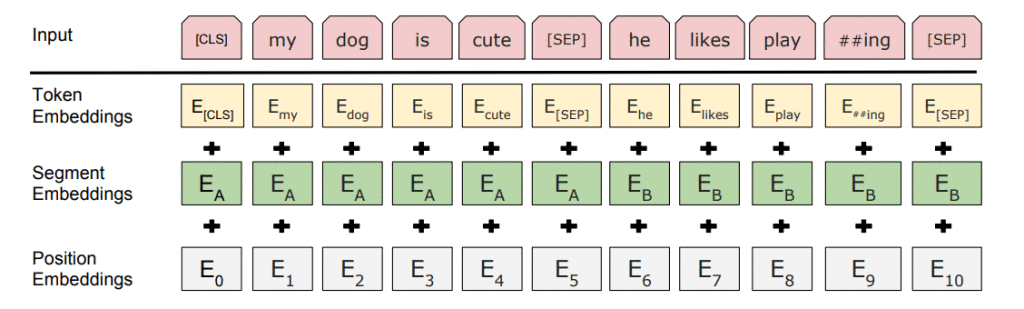



1.   **Token embeddings**: A [CLS] token is added to the input word tokens at the beginning of the first sentence and a [SEP] token is inserted at the end of each sentence.
2.   **Segment embeddings**: A marker indicating Sentence A or Sentence B is added to each token. This allows the encoder to distinguish between sentences.
3.   **Positional embeddings**: A positional embedding is added to each token to indicate its position in the sentence.
---
By means of this tokens BERT is capable of extract a model of the semantic of 
the text.<br>
Since this text preprocessor is a TensorFlow model, It can be included in the model directly.





##Defining the BERT Model

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  
  net = outputs['pooled_output']
  net = tf.keras.layers.Dense(64, activation='relu')(net)
  net = tf.keras.layers.Dropout(0.2)(net) #Regularization
  net = tf.keras.layers.Dense(32, activation='relu')(net)
  net = tf.keras.layers.Dropout(0.2)(net) #Regularization
  net = tf.keras.layers.Dense(5, activation='softmax')(net)
  return tf.keras.Model(text_input, net)

##Training and Test

In [ ]:
classifier_model = build_classifier_model()
classifier_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
classifier_model.summary()
train_history = classifier_model.fit(train_phrase, train_sentiment,  validation_data=(validation_phrase, validation_sentiment),epochs=5)

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                   

Ends up with an accuracy of 0.66 on the training set, let's see how behave on the full training set.

In [ ]:
#commented in order to avoid run
classifier_model = build_classifier_model()
classifier_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

sentiment = train['Sentiment']
sentiment = tf.keras.utils.to_categorical(sentiment, num_classes=5)

classifier_model.fit(train['Phrase'], sentiment ,batch_size = 32, epochs=5) #train on the full trainign set

#Saving the model
#classifier_model.save('/content/drive/MyDrive/NLP Sentiment Challenge/bert_model.h5')

In [ ]:
#launch this if you want to load the saved model
#classifier_model = keras.models.load_model(('/content/drive/MyDrive/NLP Sentiment Challenge/bert_model.h5'),custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
test_id = test['PhraseId']
y_prdict = classifier_model.predict(test['Phrase'])
y = np.argmax(y_prdict, axis=1)
submission = pd.DataFrame(list(zip(test_id, y)),
               columns =['PhraseId', 'Sentiment'])
submission.head(20)

submission.to_csv('/content/drive/MyDrive/NLP Sentiment Challenge/submission_bert.csv', index=False)

Ends up with a score of 0.67629 that is quite close to the most good result on Kaggle that is of 0.70.<br>
Of course tuning hyperparamenter or trying other neural structure could bring to better result.<br>
However this is a big improvement, we have to realize that is a quite unbalanced dataset with several classes and, in my humble opinion, also not so well labeled, so is quite difficult to obtain really good score.

## That's all! Thank you for your... Attention :)